# Technical Notebook

## I. Import Libraries & Data

In [132]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn.model_selection
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from scipy import stats
from yellowbrick.regressor import ResidualsPlot, PredictionError


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 1000)

In [2]:
# Import data to Pandas DataFrame
data = pd.read_csv('spotify_tracks.csv')

# Drop columns
songs = data.drop(columns=['artist_id', 
                            'track_name',  
                            'track_track_number', 
                            'track_explicit',
                            'track_album_release_date', 
                            'track_album_total_tracks',
                            'track_album_available_markets', 
                            'track_album_name', 
                            'track_album_id',
                            'track_album_available_markets_count', 
                            'duration_ms'
                            ])
# Drop duplicate rows
songs.drop_duplicates('track_id', keep='first', inplace=True)

# Preivew data
print(songs.info())
songs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637265 entries, 0 to 682192
Data columns (total 16 columns):
track_id              637265 non-null object
track_popularity      637265 non-null int64
track_duration_ms     637265 non-null int64
track_album_single    637265 non-null int64
danceability          637265 non-null float64
energy                637265 non-null float64
key                   637265 non-null float64
loudness              637265 non-null float64
mode                  637265 non-null float64
speechiness           637265 non-null float64
acousticness          637265 non-null float64
instrumentalness      637265 non-null float64
liveness              637265 non-null float64
valence               637265 non-null float64
tempo                 637265 non-null float64
time_signature        637265 non-null float64
dtypes: float64(12), int64(3), object(1)
memory usage: 82.7+ MB
None


,track_id,track_popularity,track_duration_ms,track_album_single,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0003Z98F6hUq7XxqSRM87H,26,241666,0,0.733,0.711,1.0,-5.408,1.0,0.1580,0.08600,0.0000,0.4510,0.346,138.076,4.0
1,0008brbqMd6r3WdmXEPbUq,1,189794,0,0.263,0.203,2.0,-20.025,1.0,0.0325,0.88900,0.1130,0.3170,0.142,62.553,5.0
2,0008ihzWSit1NmuXq2VBpE,11,344866,0,0.510,0.228,10.0,-17.138,1.0,0.0299,0.91400,0.6960,0.0847,0.322,128.759,4.0
3,000BARWwSRfyAAYOxPMD83,12,128219,1,0.531,0.837,0.0,-4.391,1.0,0.2740,0.00683,0.0000,0.2250,0.067,145.878,4.0
4,000CfxgH11DeiTY9oCvZLJ,30,213693,0,0.648,0.273,11.0,-4.897,1.0,0.0472,0.09410,0.0924,0.0853,0.904,145.844,4.0


## II. Linear Regression

### 1. Baseline Linear Regression

#### a) Check for Linear Relationship with Pearson's R-Value

Pearson's R represents a correlation coefficient. So a Pearson's R > .5 means there is a positive correlation between the feature. None of the features below show a positive correlation.

In [3]:
# Calculate Pearson's R-Value to check for linear relationship
songs.corr()['track_popularity'].sort_values(ascending=False)

track_popularity      1.000000
loudness              0.167253
track_album_single    0.135094
energy                0.106122
danceability          0.091792
valence               0.050353
time_signature        0.038292
tempo                 0.019250
key                   0.002758
mode                 -0.003596
liveness             -0.008387
speechiness          -0.043375
track_duration_ms    -0.064754
acousticness         -0.095788
instrumentalness     -0.147148
Name: track_popularity, dtype: float64

#### b) Check for Multicollinearity with VIF

The variance inflation factor is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

In [4]:
# Calculate VIF to check for Multicollinearity
# select only columns with datatype int64 or float 64
songs_cleaned = songs.drop(columns=['track_id'])
#cleaned_KC.select_dtypes(include=['int64','float64']).drop(axis=1, columns=['id'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Score"] = [variance_inflation_factor(songs_cleaned.values, i) for i in range(songs_cleaned.shape[1])]

# label the scores with their related columns
vif["features"] = songs_cleaned.columns

vif.round(1)

,VIF Score,features
0,2.9,track_popularity
1,4.1,track_duration_ms
2,1.3,track_album_single
3,15.9,danceability
4,19.2,energy
5,3.2,key
6,9.5,loudness
7,2.7,mode
8,1.9,speechiness
9,4.2,acousticness


If VIF > 5 there is an indication that multicollinearity may be present; with VIF > 10 there is certainly multicollinearity among the variables.

Based on first run of VIF scores, danceability, energy, tempo, and time signature clearly have multi-collinearity, thus we drop them to reduce noise.

In [5]:
# Calculate VIF to check for Multicollinearity
# select only columns with datatype int64 or float 64
songs_cleaned = songs.drop(columns=['track_id',
                                    'time_signature', 
                                    'tempo', 
                                    'danceability', 
                                    'energy', 
                                    'loudness'
                                        ])
#cleaned_KC.select_dtypes(include=['int64','float64']).drop(axis=1, columns=['id'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Score"] = [variance_inflation_factor(songs_cleaned.values, i) for i in range(songs_cleaned.shape[1])]

# label the scores with their related columns
vif["features"] = songs_cleaned.columns

vif.round(1)

,VIF Score,features
0,2.6,track_popularity
1,3.3,track_duration_ms
2,1.2,track_album_single
3,2.8,key
4,2.5,mode
5,1.7,speechiness
6,2.0,acousticness
7,1.5,instrumentalness
8,2.3,liveness
9,3.3,valence


The remaining features all have a VIF < 5.

#### c) Clean Data for Linear Regression

In [6]:
#Drop collinear columns
songs1 = songs.drop(columns=['track_id',
                             'time_signature', 
                             'tempo', 
                             'danceability', 
                             'energy', 
                             'loudness'])

#### d) Define X & Y

In [7]:
#Define appropriate X and y
X1 = songs1[songs1.columns[1:]]
y1 = songs1.track_popularity

#### e) Train-Test Split

In [8]:
# Train-Test Split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = .2)

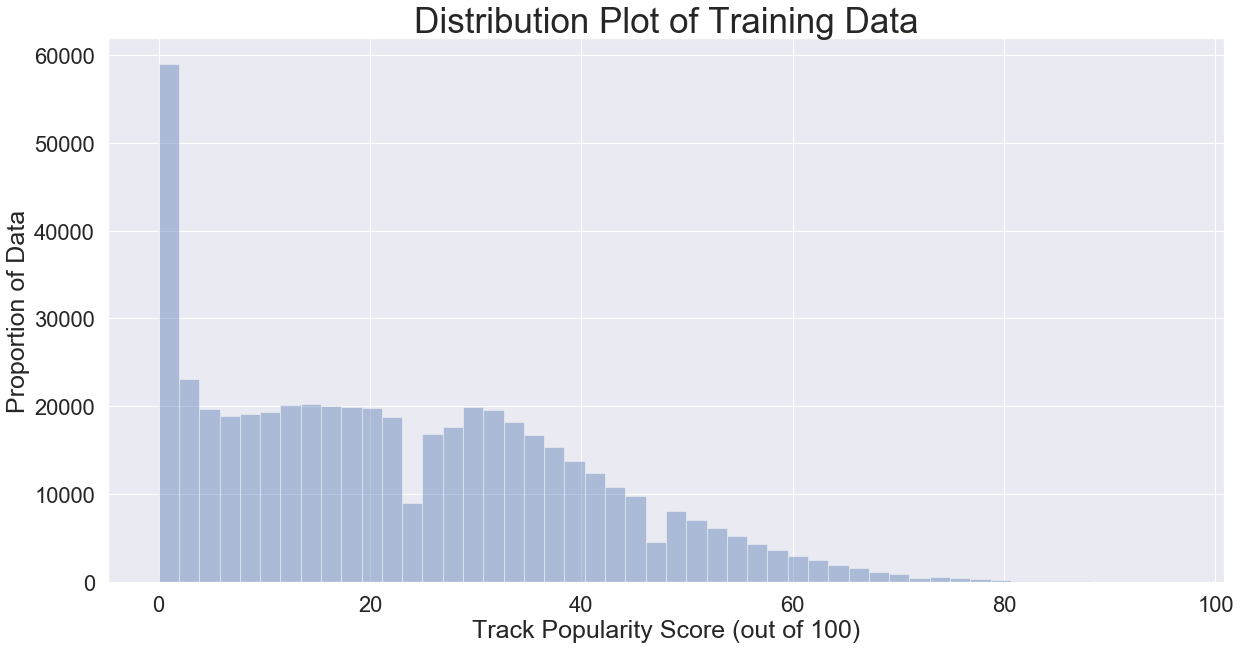

In [10]:
fig1 = plt.figure(figsize=(20,10))
sns.distplot(y1_train, kde=False)
sns.set(font_scale = 2)
plt.title("Distribution Plot of Training Data", fontsize=35)
plt.xlabel('Track Popularity Score (out of 100)', fontsize=25)
plt.ylabel('Proportion of Data', fontsize=25)
plt.show()

#### f) Normalize X Train & Test

In [11]:
# Normalize X_train & X_test
scaler = StandardScaler()

X1_train_norm = scaler.fit_transform(X1_train)
X1_test_norm = scaler.transform(X1_test)

#### g) Run Linear Regression

In [12]:
reg1 = sm.OLS(y1_train, X1_train_norm).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       track_popularity   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              936.0
Date:                Wed, 23 Oct 2019   Prob (F-statistic):                        0.00
Time:                        06:01:37   Log-Likelihood:                     -2.4297e+06
No. Observations:              509812   AIC:                                  4.859e+06
Df Residuals:                  509803   BIC:                                  4.860e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6759      0.041    -16.631      0.000      -0.756      -0.596
x2             1.9628      0.041     48.301      0.000       1.883       2.042
x3             0.0053      0.040      0.132      0.895      -0.074       0.084
x4            -0.0035      0.041     -0.085      0.932      -0.083       0.076
x5            -1.3041      0.041    -31.598      0.000      -1.385      -1.223
x6            -0.9066      0.042    -21.484      0.000      -0.989      -0.824
x7            -2.1975      0.043    -50.549      0.000      -2.283      -2.112
x8            -0.0696      0.041     -1.708      0.088      -0.150       0.010
x9             0.0064      0.043      0.149      0.882      -0.078       0.090
==============================================================================
Omnibus:                    22897.086   Durbin-Watson:                   0.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23513.944
Skew:                           0.493   Prob(JB):                         0.00
Kurtosis:                       2.633   Cond. No.                         1.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### h) QQ Plot

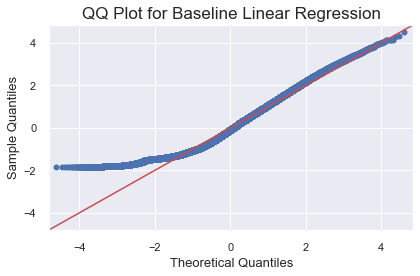

In [14]:
residuals = reg1.resid
fig2 = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
sns.set(font_scale = 1)
plt.title("QQ Plot for Baseline Linear Regression", fontsize=17)
plt.xlabel('Theoretical Quantiles', fontsize=13)
plt.ylabel('Sample Quantiles', fontsize=13)
plt.tight_layout()
plt.show()
fig2.savefig('Images/baseline_linear_regression_qq_plot.png')

### 2. Linear Regression w/ Binned Dependent Variable

#### a) Binning Independent Variable & Creating New DataFrame

In [15]:
# Create new dataframe
songs2 = songs1.copy()

In [16]:
# Bin independent variable
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
songs2['track_popularity_bins'] = pd.cut(songs1['track_popularity'], bins=bins, labels=labels)

In [17]:
# Drop 0 popularity
songs2.dropna(inplace=True)

In [18]:
# Encoding categorical data
le = LabelEncoder()
songs2['track_popularity'] = le.fit_transform(songs2['track_popularity'])

In [19]:
# Independent variable value counts
songs2.track_popularity_bins.value_counts()

10     131599
20     124880
30     115033
40     104735
50      61421
60      30220
70      11257
80       2947
90        413
100        31
Name: track_popularity_bins, dtype: int64

#### b) Re-define X & Y

In [20]:
#Define appropriate X and y
X2 = songs2[songs2.columns[1:-1]]
y2 = songs2.track_popularity_bins

#### c) Train-Test Split

In [21]:
# Train-Test Split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = .2)

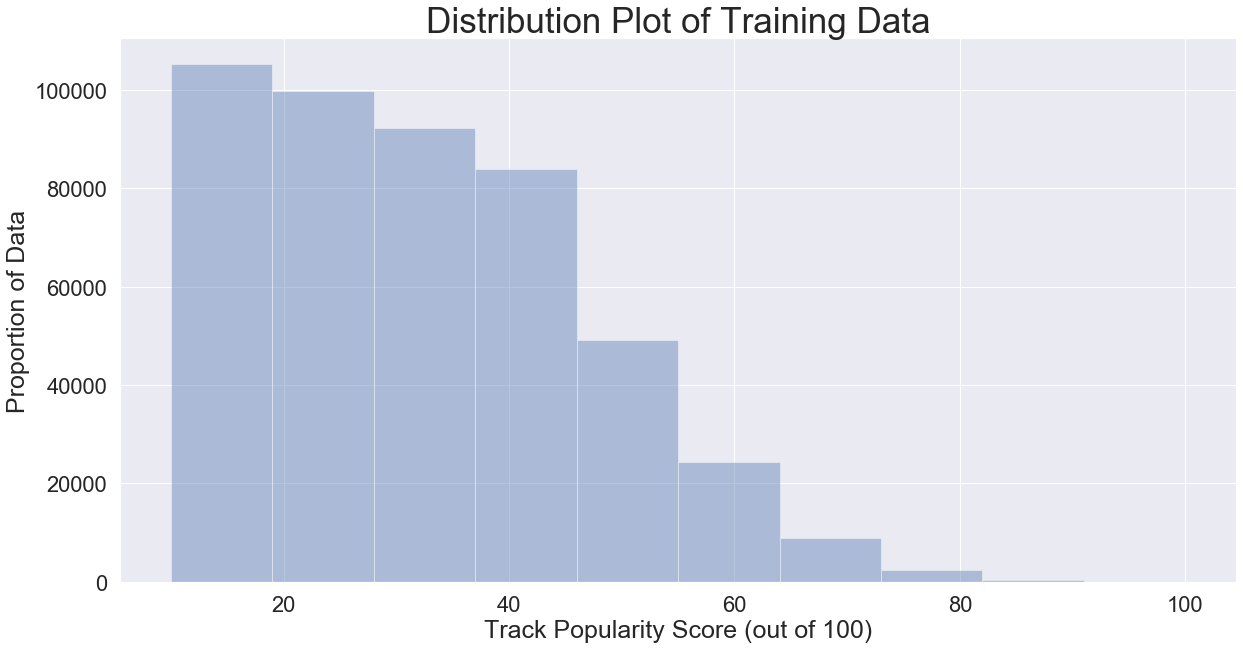

In [23]:
fig3 = plt.figure(figsize=(20,10))
sns.distplot(y2_train, kde=False, bins=10)
sns.set(font_scale = 2)
plt.title("Distribution Plot of Training Data", fontsize=35)
plt.xlabel('Track Popularity Score (out of 100)', fontsize=25)
plt.ylabel('Proportion of Data', fontsize=25)
plt.show()

#### d) Normalize X Train & Test

In [24]:
# Normalize X_train & X_test
scaler = StandardScaler()

X2_train_norm = scaler.fit_transform(X2_train)
X2_test_norm = scaler.transform(X2_test)

#### e) Run Linear Regression

In [25]:
reg2 = sm.OLS(y2_train, X2_train_norm).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     track_popularity_bins   R-squared (uncentered):                   0.009
Model:                               OLS   Adj. R-squared (uncentered):              0.009
Method:                    Least Squares   F-statistic:                              462.3
Date:                   Wed, 23 Oct 2019   Prob (F-statistic):                        0.00
Time:                           06:02:11   Log-Likelihood:                     -2.3029e+06
No. Observations:                 466028   AIC:                                  4.606e+06
Df Residuals:                     466019   BIC:                                  4.606e+06
Df Model:                              9                                                  
Covariance Type:               nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4550      0.051     -8.992      0.000      -0.554      -0.356
x2             1.7462      0.051     34.469      0.000       1.647       1.845
x3             0.0067      0.050      0.132      0.895      -0.092       0.105
x4            -0.0630      0.051     -1.244      0.213      -0.162       0.036
x5            -1.0178      0.051    -19.778      0.000      -1.119      -0.917
x6            -0.9569      0.053    -18.145      0.000      -1.060      -0.854
x7            -1.8795      0.054    -34.616      0.000      -1.986      -1.773
x8            -0.1370      0.051     -2.692      0.007      -0.237      -0.037
x9            -0.0405      0.054     -0.756      0.450      -0.145       0.064
==============================================================================
Omnibus:                    22539.611   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25109.854
Skew:                           0.554   Prob(JB):                         0.00
Kurtosis:                       2.747   Cond. No.                         1.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### f) QQ Plot

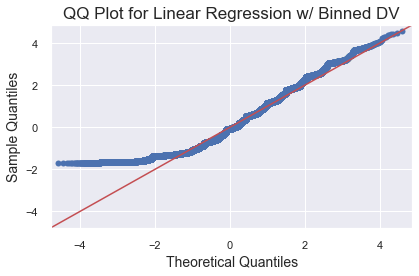

In [27]:
residuals = reg2.resid

fig4 = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
sns.set(font_scale = 1)
plt.title("QQ Plot for Linear Regression w/ Binned DV", fontsize=17)
plt.xlabel('Theoretical Quantiles', fontsize=14)
plt.ylabel('Sample Quantiles', fontsize=14)
plt.tight_layout()
plt.show()
fig4.savefig('Images/linear_regression2_qq_plot.png')

### 3. Linear Regression w/ Target Transformation (Adjusting Noise & Number of Features)

#### a) Linear Regression w/ Noise Limited to 100

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.578
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                              272.9
Date:                Wed, 23 Oct 2019   Prob (F-statistic):                   1.07e-183
Time:                        06:02:27   Log-Likelihood:                         -6007.4
No. Observations:                1000   AIC:                                  1.202e+04
Df Residuals:                     995   BIC:                                  1.205e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            18.2583      3.103      5.884      0.000      12.169      24.347
x2            93.1701      3.145     29.629      0.000      86.999      99.341
x3            39.1763      3.137     12.487      0.000      33.020      45.333
x4            38.4860      3.115     12.353      0.000      32.372      44.600
x5            32.6073      3.079     10.591      0.000      26.566      38.649
==============================================================================
Omnibus:                        6.652   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                7.771
Skew:                          -0.101   Prob(JB):                       0.0205
Kurtosis:                       3.382   Cond. No.                         1.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

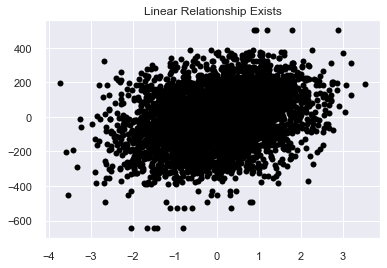

In [28]:
from sklearn.datasets.samples_generator import make_regression
X1_train, y1_train = make_regression(n_samples=1000, n_features=5, noise=100)

plt.plot(X1_train, y1_train, 'o', color='black');
plt.title("Linear Relationship Exists")

reg4 = sm.OLS(y1_train, X1_train).fit()
reg4.summary()

#### b) Linear Regression w/ Noise Limited to 10

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          3.516e+04
Date:                Wed, 23 Oct 2019   Prob (F-statistic):                        0.00
Time:                        06:02:32   Log-Likelihood:                         -3694.6
No. Observations:                1000   AIC:                                      7399.
Df Residuals:                     995   BIC:                                      7424.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            45.4289      0.311    146.082      0.000      44.819      46.039
x2            82.3186      0.303    271.710      0.000      81.724      82.913
x3            38.8355      0.303    128.285      0.000      38.241      39.430
x4            53.2895      0.304    175.073      0.000      52.692      53.887
x5            60.5863      0.314    193.205      0.000      59.971      61.202
==============================================================================
Omnibus:                        0.880   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.938
Skew:                           0.020   Prob(JB):                        0.626
Kurtosis:                       2.855   Cond. No.                         1.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

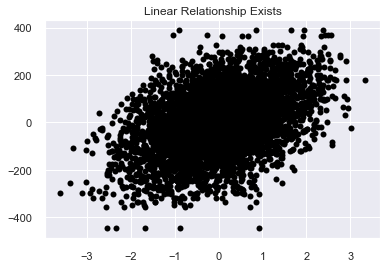

In [29]:
from sklearn.datasets.samples_generator import make_regression
X1_train, y1_train = make_regression(n_samples=1000, n_features=5, noise=10)

plt.plot(X1_train, y1_train, 'o', color='black');
plt.title("Linear Relationship Exists")

reg4 = sm.OLS(y1_train, X1_train).fit()
reg4.summary()

#### c) QQ Plot

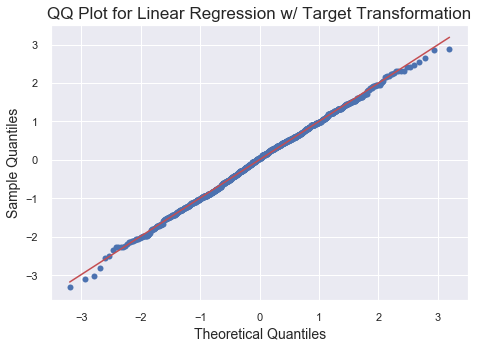

In [30]:
fig4b = plt.figure(figsize=(7,5))
stats.probplot(X1_train[:,0], dist="norm", plot=plt)
sns.set(font_scale = 1)
plt.title("QQ Plot for Linear Regression w/ Target Transformation", fontsize=17)
plt.xlabel('Theoretical Quantiles', fontsize=14)
plt.ylabel('Sample Quantiles', fontsize=14)
plt.tight_layout()
plt.show()
fig4b.savefig('Images/transformed_linear_regression_qq_plot.png')

#### d) Linear Regression w/ Data Transformed Using Yeo-Johnson Method

In [31]:
# transform training data & save lambda value
from sklearn.preprocessing import power_transform
# use lambda value to transform test data
X2_train_trans = power_transform(X2_train_norm, method='yeo-johnson', standardize=True)
# use lambda value to transform test data
X2_test_trans = power_transform(X2_test_norm, method='yeo-johnson', standardize=True)

In [32]:
reg3 = sm.OLS(y2_train, X2_train_trans).fit()
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     track_popularity_bins   R-squared (uncentered):                   0.009
Model:                               OLS   Adj. R-squared (uncentered):              0.009
Method:                    Least Squares   F-statistic:                              461.4
Date:                   Wed, 23 Oct 2019   Prob (F-statistic):                        0.00
Time:                           06:02:52   Log-Likelihood:                     -2.3029e+06
No. Observations:                 466028   AIC:                                  4.606e+06
Df Residuals:                     466019   BIC:                                  4.606e+06
Df Model:                              9                                                  
Covariance Type:               nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0943      0.051     -1.844      0.065      -0.195       0.006
x2             1.8056      0.051     35.561      0.000       1.706       1.905
x3             0.0115      0.050      0.229      0.819      -0.087       0.110
x4            -0.1238      0.051     -2.441      0.015      -0.223      -0.024
x5            -1.0093      0.052    -19.290      0.000      -1.112      -0.907
x6            -0.9450      0.052    -18.034      0.000      -1.048      -0.842
x7            -2.1157      0.054    -39.495      0.000      -2.221      -2.011
x8            -0.2455      0.050     -4.876      0.000      -0.344      -0.147
x9             0.0761      0.054      1.414      0.157      -0.029       0.182
==============================================================================
Omnibus:                    22558.026   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25150.603
Skew:                           0.555   Prob(JB):                         0.00
Kurtosis:                       2.749   Cond. No.                         1.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## III. Logistic Regression

### 1. Create New DataFrame w/ Binary Dependent Variable  

#### a) Copy DataFrame

In [33]:
# Create new dataframe
songs3 = songs1.copy()

#### b) Create Binary Dependent Variable Column

In [34]:
# Create binary column for track_popularity over/under 50
songs3['track_popularity_50'] = np.where(songs3['track_popularity']>50, 1, 0)

#### d) Define X & Y

In [35]:
#Define appropriate X and y
X3 = songs3[songs3.columns[1:-1]]
y3 = songs3.track_popularity_50

#### c) Train-Test Split

In [36]:
# Train-Test Split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, 
                                                        stratify = y3,
                                                        test_size = .2)

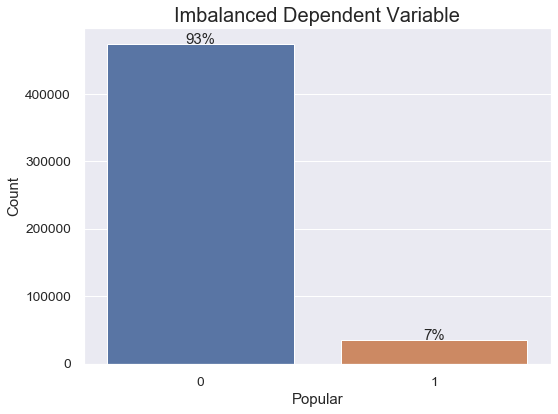

In [38]:
y3_train_df = pd.DataFrame(y3_train)
total = float(len(y3_train_df))

fig5 = plt.figure(figsize=(8,6))
ax = sns.countplot(x='track_popularity_50', data=y3_train_df)
plt.title("Imbalanced Dependent Variable", fontsize=20)
plt.xlabel('Popular', fontsize=15)
plt.ylabel('Count', fontsize=15)
sns.set(font_scale = 1.25)
plt.tight_layout()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 40,
            '{0:.0%}'.format(height/total),
            ha="center") 
plt.show()
fig5.savefig('Images/imbalanced_dependent_variable.png')

#### d) Normalize X_train & X_test

In [39]:
# Normalize X_train & X_test
scaler = StandardScaler()
X3_train_norm = scaler.fit_transform(X3_train)
X3_test_norm = scaler.transform(X3_test)

#### e) Identify Data Imbalance

In [40]:
# Identify data imbalance
y3_train.value_counts()

0    473918
1     35894
Name: track_popularity_50, dtype: int64

### 2. Run Baseline Logistic Regression

#### a) Run Logistic Regression

In [41]:
lr1 = LogisticRegression(solver='liblinear').fit(X3_train_norm, y3_train)
lr1_pred = lr1.predict(X3_test_norm)

#### b) Scores

In [42]:
# Checking Accuracy
print('Accuracy:', accuracy_score(y3_test, lr1_pred))

# Checking Precision
print('Precision:', precision_score(y3_test, lr1_pred))
    
# F1 Score
print('F1:', f1_score(y3_test, lr1_pred))

# Checking Recall
print('Recall:', recall_score(y3_test, lr1_pred))

Accuracy: 0.9295897311165685
Precision: 0.0
F1: 0.0
Recall: 0.0


#### c) ROC Curve

In [43]:
y_hat_test = lr1.predict(X3_test_norm)
y_score = lr1.decision_function(X3_test_norm)

fpr, tpr, threshold = roc_curve(y3_test, y_score)
roc_auc = auc(fpr, tpr)

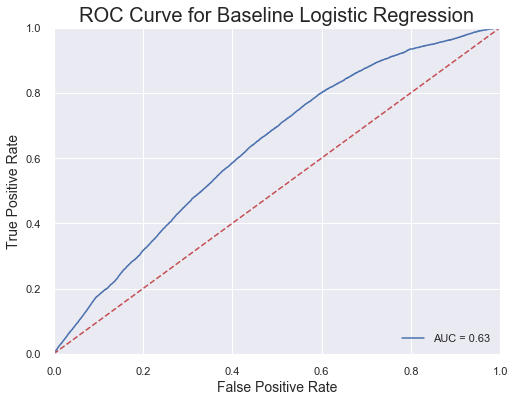

In [45]:
# method I: plt
fig6 = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
sns.set(font_scale = 1)
plt.title('ROC Curve for Baseline Logistic Regression', fontsize=20)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()
fig6.savefig('Images/ROC_baseline.png')

#### d) Recall-Precision Curve

f1=0.000 auc=0.535


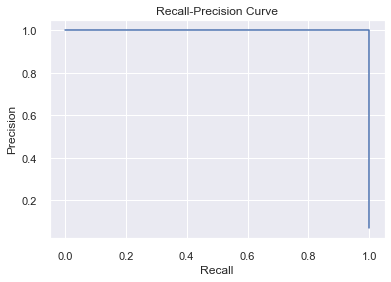

In [46]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
# calculate precision and recall for each threshold
precision, recall, threshold = precision_recall_curve(y3_test, lr1.predict(X3_test_norm))
# calculate scores
f1, auc = f1_score(y3_test, lr1.predict(X3_test_norm)), auc(recall, precision)
# summarize scores
print('f1=%.3f auc=%.3f' % (f1, auc))
# plot the precision-recall curves
# plt.plot(recall, precision)
plt.step(recall, precision)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
# show the plot
plt.show();

## IV. Logistic Regression w/ Balanced Data

### 1. Balancing Method 1: Oversample Minority Class

#### a) Balance Data by Oversampling Minority Class

In [47]:
# Convert Numpy array to DataFrame
X3_train_norm_df = pd.DataFrame(X3_train_norm)

In [48]:
# Concatenate our training data back together
X3_train_norm_df = X3_train_norm_df.reset_index()
y3_train = y3_train.reset_index()
X4 = pd.concat([X3_train_norm_df, y3_train], axis=1, ignore_index=True)

In [49]:
# Separate minority and majority classes
not_popular = X4[X4[11]==0]
popular = X4[X4[11]==1]

# Upsample minority
popular_upsampled = resample(popular,
                          replace=True, # sample with replacement
                          n_samples=len(not_popular), # match number in majority class
                          random_state=27) # reproducible results

# Combine majority and upsampled minority
upsampled = pd.concat([not_popular, popular_upsampled])

# Check new class counts
upsampled[11].value_counts()

1    473918
0    473918
Name: 11, dtype: int64

#### b) Train-Test Split by Balanced Data

In [50]:
y4_train = upsampled[upsampled.columns[-1:]]
X4_train = upsampled[upsampled.columns[1:-2]]

#### c) Visualize Balanced Data

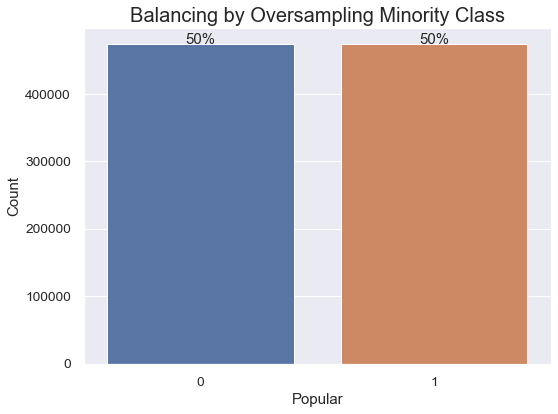

In [52]:
# Visualize Balanced Data
y4_train_df = pd.DataFrame(y4_train)
total = float(len(y4_train_df))

fig7 = plt.figure(figsize=(8,6))
ax = sns.countplot(x=11, data=y4_train_df)
plt.title("Balancing by Oversampling Minority Class", fontsize=20)
plt.xlabel('Popular', fontsize=15)
plt.ylabel('Count', fontsize=15)
sns.set(font_scale = 1.25)
plt.tight_layout()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 40,
            '{0:.0%}'.format(height/total),
            ha="center") 
plt.show()
fig7.savefig('Images/balance_by_oversampling_minority.png')

#### d) Logistic Regression w/ Oversampled Minority Balanced Data

In [53]:
upsampled_lr = LogisticRegression(solver='liblinear').fit(X4_train, y4_train)
upsampled_pred = upsampled_lr.predict(X3_test_norm)

#### e) Scores

In [54]:
# Checking Accuracy
print('Accuracy:', accuracy_score(y3_test, upsampled_pred))

# Checking Precision
print('Precision:', precision_score(y3_test, upsampled_pred))
    
# F1 Score
print('F1:', f1_score(y3_test, upsampled_pred))

# Checking Recall
print('Recall:', recall_score(y3_test, upsampled_pred))

Accuracy: 0.479918087451845
Precision: 0.0937048064653339
F1: 0.16625578587240894
Recall: 0.7364608870069088


### 2. Balancing Method 2: Undersample Majority Class

#### a) Balance by Undersampling Majority Class

In [55]:
# still using our separated classes popular and not_popular from above

# downsample majority
not_popular_downsampled = resample(not_popular,
                                replace = False, # sample without replacement
                                n_samples = len(popular), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_popular_downsampled, popular])

# checking counts
downsampled[11].value_counts()

1    35894
0    35894
Name: 11, dtype: int64

#### b) Train-Test Split w/ Blanaced Data

In [56]:
y5_train = downsampled[downsampled.columns[-1:]]
X5_train = downsampled[downsampled.columns[1:-2]]

#### c) Visualize Balanced Data

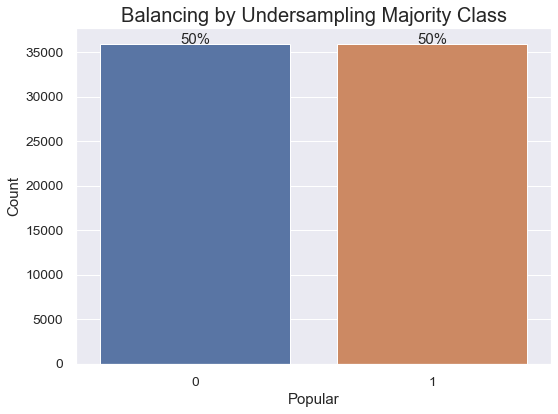

In [57]:
y5_train_df = pd.DataFrame(y5_train)
total = float(len(y5_train_df))

fig8 = plt.figure(figsize=(8,6))
ax = sns.countplot(x=11, data=y5_train_df)
plt.title("Balancing by Undersampling Majority Class", fontsize=20)
plt.xlabel('Popular', fontsize=15)
plt.ylabel('Count', fontsize=15)
sns.set(font_scale = 1.25)
plt.tight_layout()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 40,
            '{0:.0%}'.format(height/total),
            ha="center") 
plt.show()
fig8.savefig('Images/balanced_by_undersampling_majoirty.png')

#### d) Logistic Regression w/ Undersampled Majority Balanced Data

In [58]:
downsampled_lr = LogisticRegression(solver='liblinear').fit(X5_train, y5_train)
downsampled_pred = downsampled_lr.predict(X3_test_norm)

#### e) Scores

In [59]:
# Checking Accuracy
print('Accuracy:', accuracy_score(y3_test, downsampled_pred))

# Checking Precision
print('Precision:', precision_score(y3_test, downsampled_pred))
    
# F1 Score
print('F1:', f1_score(y3_test, downsampled_pred))

# Checking Recall
print('Recall:', recall_score(y3_test, downsampled_pred))

Accuracy: 0.47773689124618485
Precision: 0.09380730709550007
F1: 0.16653310628067713
Recall: 0.7410296411856474


### 3. Balancing Method 3: Generate Synthetic Samples w/ SMOTE

#### a) Balancing Using SMOTE

In [61]:
# Drop index column in y3_train
y3_train = y3_train.drop(columns=['index'])

In [118]:
print(y3_train.track_popularity_50.value_counts())
smote = SMOTE()
X3_train_norm_resampled, y3_train_resampled = smote.fit_sample(X3_train_norm, y3_train.track_popularity_50) 
print(pd.Series(y3_train_resampled).value_counts())

0    473918
1     35894
Name: track_popularity_50, dtype: int64
1    473918
0    473918
dtype: int64


#### b) Visualize Balanced Data

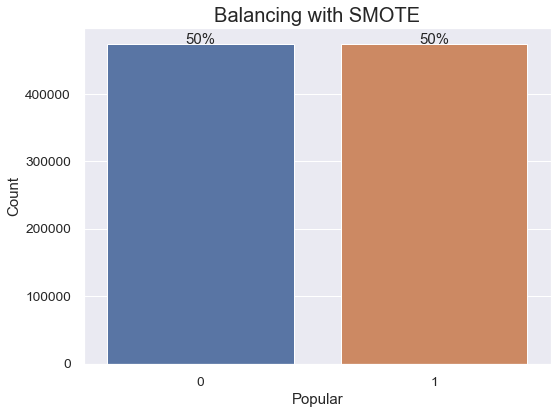

In [65]:
y3_train_resampled_df = pd.DataFrame(y3_train_resampled)
total = float(len(y3_train_resampled_df))

fig9 = plt.figure(figsize=(8,6))
ax = sns.countplot(x=0, data=y3_train_resampled_df)
plt.title("Balancing with SMOTE", fontsize=20)
plt.xlabel('Popular', fontsize=15)
plt.ylabel('Count', fontsize=15)
sns.set(font_scale = 1.25)
plt.tight_layout()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 40,
            '{0:.0%}'.format(height/total),
            ha="center") 
plt.show()
fig9.savefig('Images/balance_with_smote.png')

#### c) Run Logistic Regression w/ SMOTE Balanced Data

In [73]:
smote = LogisticRegression(solver='liblinear').fit(X3_train_norm_resampled, y3_train_resampled)
smote_pred = smote.predict(X3_test_norm)

#### d) Scores

In [74]:
# Checking Accuracy
print('Accuracy:', accuracy_score(y3_test, smote_pred))

# Checking Precision
print('Precision:', precision_score(y3_test, smote_pred))
    
# F1 Score
print('F1:', f1_score(y3_test, smote_pred))

# Checking Recall
print('Recall:', recall_score(y3_test, smote_pred))

Accuracy: 0.48604583650443695
Precision: 0.093833972783837
F1: 0.1662317826003946
Recall: 0.7276576777356809


#### e) ROC Curve

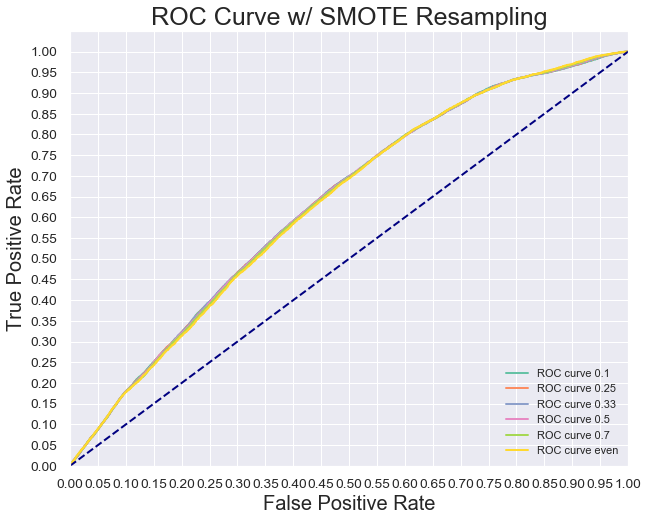

In [68]:
# Compare a few different ratios of minority class to majority class
ratios = [0.1,0.25, 0.33, 0.5,0.7,1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette("Set2")

fig6b = plt.figure(figsize=(10,8))

for n, ratio in enumerate(ratios):
    #Fit a model
    smote = SMOTE(sampling_strategy=ratio) # SMOTE
    X3_train_norm_resampled, y3_train_resampled = smote.fit_sample(X3_train_norm, y3_train) 
    logreg = LogisticRegression(fit_intercept = False, C = 1e12,solver ='lbfgs') #Starter code
    model_log = logreg.fit(X3_train_norm_resampled, y3_train_resampled)
    #print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X3_test_norm)

    y_score = logreg.decision_function(X3_test_norm)

    fpr, tpr, thresholds = roc_curve(y3_test, y_score)
    
    #print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    fig10 = plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
sns.set(font_scale = 1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve w/ SMOTE Resampling', fontsize=25)
plt.legend(loc="lower right")
plt.show()
fig6b.savefig('Images/log_roc2.png')

#### f) Recall-Precision Curve

In [75]:
print('SMOTE AUC:', roc_auc_score(y3_test, smote.predict(X3_test_norm)))
print('Baseline AUC:', roc_auc_score(y3_test, lr1.predict(X3_test_norm)))

SMOTE AUC: 0.5977015082860495
Baseline AUC: 0.5


f1=0.166 auc=0.420


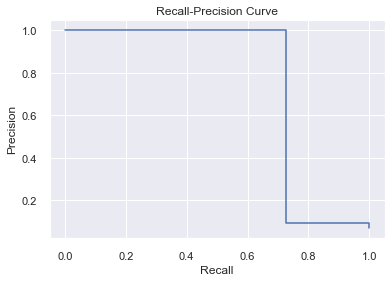

In [76]:
# calculate precision and recall for each threshold
precision, recall, threshold = precision_recall_curve(y3_test, smote.predict(X3_test_norm))
# calculate scores
f1, auc = f1_score(y3_test, smote.predict(X3_test_norm)), auc(recall, precision)
# summarize scores
print('f1=%.3f auc=%.3f' % (f1, auc))
# plot the precision-recall curves
# plt.plot(recall, precision)
plt.step(recall, precision)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
# show the plot
plt.show();

## V. Logistic Regression w/ Cross Validation

In [77]:
#split into 10 stratified
cv = StratifiedKFold(n_splits= 10, random_state=1019, shuffle=True)

#pick sections to compare
lr_vanilla = LogisticRegression(C = 1e9, 
                                solver = 'newton-cg',
                                max_iter=1000)

l2_reg = LogisticRegression(C = 1, 
                            solver = 'newton-cg',
                            max_iter=1000)

l1_reg = LogisticRegression(C = 1, 
                           solver= 'saga', 
                           penalty = 'l1',
                            max_iter=1000)

#cross validations (each has different methods)
cv_vanilla = cross_validate(estimator=lr_vanilla, 
                            X = X3_train_norm_resampled, y = y3_train_resampled,
                            cv = cv, 
                            n_jobs=-1, 
                            return_estimator= True, 
                            return_train_score=True)

cv_l2 = cross_validate(estimator=l2_reg, 
                    X = X3_train_norm_resampled, y = y3_train_resampled,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)

cv_l1 = cross_validate(estimator=l1_reg, 
                    X = X3_train_norm_resampled, y = y3_train_resampled,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)


In [78]:
# Vanilla Result
vanilla_result = np.concatenate((cv_vanilla['train_score'].reshape(-1,1), 
                cv_vanilla['test_score'].reshape(-1,1)), axis=1)
print('Vanilla Result:')
print(vanilla_result)

# L2 Result
l2_result = np.concatenate((cv_l2['train_score'].reshape(-1,1), 
                cv_l2['test_score'].reshape(-1,1)), axis=1)
print('L2 Result:')
print(l2_result)

# L1 Result
l1_result = np.concatenate((cv_l1['train_score'].reshape(-1,1), 
                cv_l1['test_score'].reshape(-1,1)), axis=1)
print('L1 Result:')
print(l1_result)

# Mean Comparison
print(vanilla_result.mean(axis=0), l1_result.mean(axis=0), l2_result.mean(axis=0))

# Standard Deviation Comparison
print(vanilla_result.std(axis=0), l1_result.std(axis=0), l2_result.std(axis=0))

Vanilla Result:
[[0.60554925 0.60348793]
 [0.60538631 0.60503883]
 [0.60538162 0.60472232]
 [0.60537693 0.6057668 ]
 [0.60546719 0.60475397]
 [0.60537224 0.60538699]
 [0.60498305 0.60863648]
 [0.60563131 0.60310812]
 [0.60510706 0.60738326]
 [0.60543764 0.6052204 ]]
L2 Result:
[[0.60554925 0.60348793]
 [0.60538631 0.60503883]
 [0.60538162 0.60472232]
 [0.6053781  0.6057668 ]
 [0.60546719 0.60475397]
 [0.60537224 0.60538699]
 [0.60498305 0.60863648]
 [0.60563131 0.60310812]
 [0.60510823 0.60738326]
 [0.60543647 0.6052204 ]]
L1 Result:
[[0.60554808 0.60347738]
 [0.60538279 0.60502827]
 [0.60538396 0.60472232]
 [0.60537341 0.6057668 ]
 [0.60546485 0.60475397]
 [0.60537224 0.60538699]
 [0.6049807  0.60865758]
 [0.60563365 0.60310812]
 [0.60510589 0.60739381]
 [0.60543998 0.6052204 ]]
[0.60536926 0.60535051] [0.60536856 0.60535156] [0.60536938 0.60535051]
[0.00018269 0.00156417] [0.00018352 0.00157145] [0.00018248 0.00156417]


In [79]:
lr_vanilla = cv_vanilla['estimator'][0]
lr_vanilla.score(X3_train_norm_resampled, y3_train_resampled)

0.6053431184297705

In [80]:
lr_cv12 = cv_l2['estimator'][0]
lr_cv12.score(X3_train_norm_resampled, y3_train_resampled)

0.6053431184297705

In [81]:
lr_cvl1 = cv_l1['estimator'][0]
lr_cvl1.score(X3_train_norm_resampled, y3_train_resampled)

0.6053410083600961

## VI. Random Forest

### 1. Random Forest Classifier

#### a) Set Random Forrest Model

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# train model
rfc = RandomForestClassifier(n_estimators=9).fit(X3_train, y3_train)

#predict on test set
rfc_pred = rfc.predict(X3_test)

#### b) Scores

In [83]:
# Checking Accuracy
print('Accuracy:', metrics.accuracy_score(y3_test, rfc_pred))

# Checking Precision
print('Precision:', metrics.precision_score(y3_test, rfc_pred))
    
# F1 Score
print('F1:', metrics.f1_score(y3_test, rfc_pred))

# Checking Recall
print('Recall:', metrics.recall_score(y3_test, rfc_pred))

Accuracy: 0.927220230202506
Precision: 0.12990196078431374
F1: 0.01129823065444468
Recall: 0.005905950523735235


#### c) ROC Curve

Recall Baseline: 1.0 Test: 0.01 Train: 0.86
Precision Baseline: 0.07 Test: 0.13 Train: 1.0
Roc Baseline: 0.5 Test: 0.57 Train: 1.0


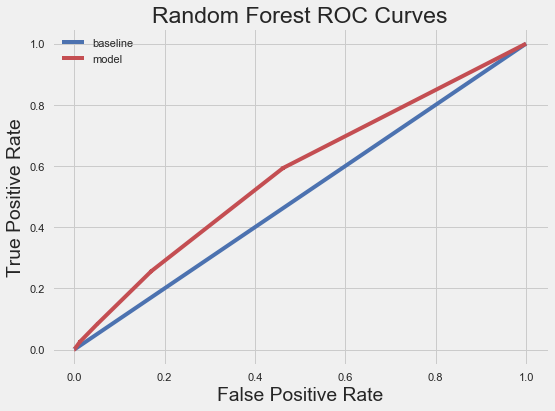

In [131]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = rfc.predict(X3_train)
train_rf_probs = rfc.predict_proba(X3_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = rfc.predict(X3_test)
rf_probs = rfc.predict_proba(X3_test)[:, 1]

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y3_test, 
                                     [1 for _ in range(len(y3_test))])
    baseline['precision'] = precision_score(y3_test, 
                                      [1 for _ in range(len(y3_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y3_test, predictions)
    results['precision'] = precision_score(y3_test, predictions)
    results['roc'] = roc_auc_score(y3_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y3_train, train_predictions)
    train_results['precision'] = precision_score(y3_train, train_predictions)
    train_results['roc'] = roc_auc_score(y3_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y3_test, [1 for _ in range(len(y3_test))])
    model_fpr, model_tpr, _ = roc_curve(y3_test, probs)

    fig11 = plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); 
    plt.title('Random Forest ROC Curves');
    plt.tight_layout()
    plt.show();
    fig11.savefig('Images/rf_roc_auc_curve.png')
    
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

#### d) Confusion Matrix

In [84]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
rf_cm = confusion_matrix(y3_test, rfc_pred)
rf_cm

array([[118124,    355],
       [  8921,     53]])

In [85]:
pd.DataFrame(confusion_matrix(y3_test, rfc_pred), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,118124,355
actual 1,8921,53


Confusion matrix, without normalization
[[118124    355]
 [  8921     53]]


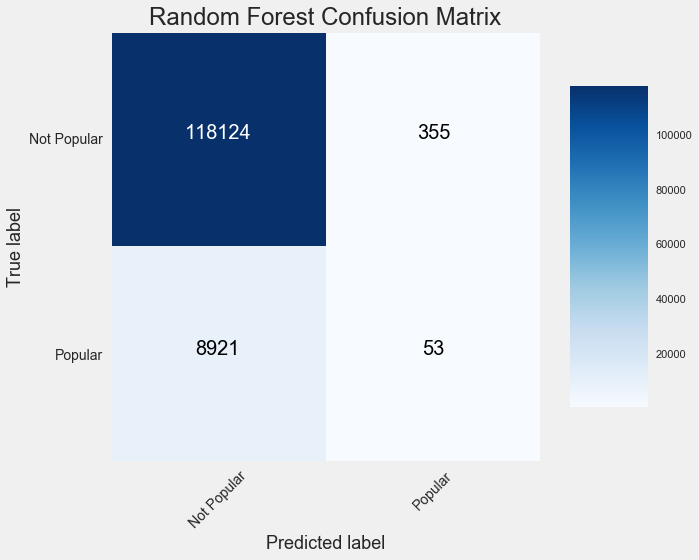

In [114]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(rf_cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        rf_cm = rf_cm.astype('float') / rf_cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(rf_cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(rf_cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = rf_cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(rf_cm.shape[0]), range(rf_cm.shape[1])):
        plt.text(j, i, format(rf_cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if rf_cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.tight_layout()
    plt.savefig('Images/rf_confusion_matrix.png')

# Confusion matrix
rf_cm = confusion_matrix(y3_test, rf_predictions)
plot_confusion_matrix(rf_cm, classes = ['Not Popular', 'Popular'],
                      title = 'Random Forest Confusion Matrix')

### 2. Random Forest Classifier w/ Cross Validation

#### a) Set Random Forest Model

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

clf = RandomForestClassifier() #Initialize with whatever parameters you want to

# 10-Fold Cross validation
clf_pred = np.mean(cross_val_score(clf, X3_train, 
                                   y3_train, cv=10))

In [92]:
clf_pred

0.9289385103974344

#### b) Set Cross Validation Model

In [93]:
cv_model = cross_validate(clf, 
                          X3_train, 
                          y3_train, 
                          cv=10, 
                          return_estimator=True)

In [94]:
y_test_pred = []
for i in range(9):
    y_test_pred.append(cv_model['estimator'][i].predict(X3_test))

In [95]:
np.mean(y_test_pred)

0.0010600857658204289

#### c) Scores

In [96]:
# Checking Accuracy
y_test_pred_accuracy = []
for i in range(9):
    y_test_pred_accuracy.append(metrics.accuracy_score(y3_test, y_test_pred[i]))
print('Accuracy:', np.mean(y_test_pred_accuracy))

# Checking Precision
y_test_pred_precision= []
for i in range(9):
    y_test_pred_precision.append(metrics.precision_score(y3_test, y_test_pred[i]))
print('Precision:', np.mean(y_test_pred_precision))
    
# F1 Score
y_test_pred_f1 = []
for i in range(9):
    y_test_pred_f1.append(metrics.f1_score(y3_test, y_test_pred[i]))
print('F1:', np.mean(y_test_pred_f1))

# Checking Recall
y_test_pred_recall = []
for i in range(9):
    y_test_pred_recall.append(metrics.recall_score(y3_test, y_test_pred[i]))
print('Recall:', np.mean(y_test_pred_recall))

Accuracy: 0.9288522043419927
Precision: 0.1516078649592632
F1: 0.004512121456601917
Recall: 0.002290567813188718


#### d) ROC Curve

Recall Baseline: 1.0 Test: 0.0 Train: 0.71
Precision Baseline: 0.07 Test: 0.15 Train: 1.0
Roc Baseline: 0.5 Test: 0.58 Train: 0.97


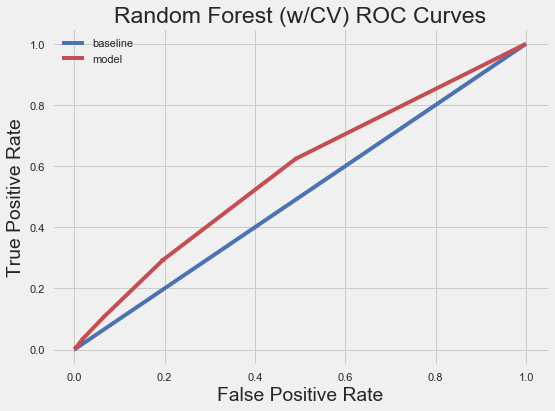

In [130]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = cv_model['estimator'][i].predict(X3_train)
train_rf_probs = cv_model['estimator'][i].predict_proba(X3_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = cv_model['estimator'][i].predict(X3_test)
rf_probs = cv_model['estimator'][i].predict_proba(X3_test)[:, 1]

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y3_test, 
                                     [1 for _ in range(len(y3_test))])
    baseline['precision'] = precision_score(y3_test, 
                                      [1 for _ in range(len(y3_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y3_test, predictions)
    results['precision'] = precision_score(y3_test, predictions)
    results['roc'] = roc_auc_score(y3_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y3_train, train_predictions)
    train_results['precision'] = precision_score(y3_train, train_predictions)
    train_results['roc'] = roc_auc_score(y3_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y3_test, [1 for _ in range(len(y3_test))])
    model_fpr, model_tpr, _ = roc_curve(y3_test, probs)

    fig13 = plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); 
    plt.title('Random Forest (w/CV) ROC Curves');
    plt.tight_layout()
    plt.show();
    #fig13.savefig('Images/rf_cv_roc_auc_curve.png')

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)


#### e) Confusion Matrix

In [97]:
y_test_predictors = cv_model['estimator'][i].predict(X3_test)

In [98]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
rf_cv_cm = confusion_matrix(y3_test, y_test_predictors)
rf_cv_cm

array([[118368,    111],
       [  8955,     19]])

In [99]:
pd.DataFrame(confusion_matrix(y3_test, y_test_predictors), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,118368,111
actual 1,8955,19


Confusion matrix, without normalization
[[118368    111]
 [  8955     19]]


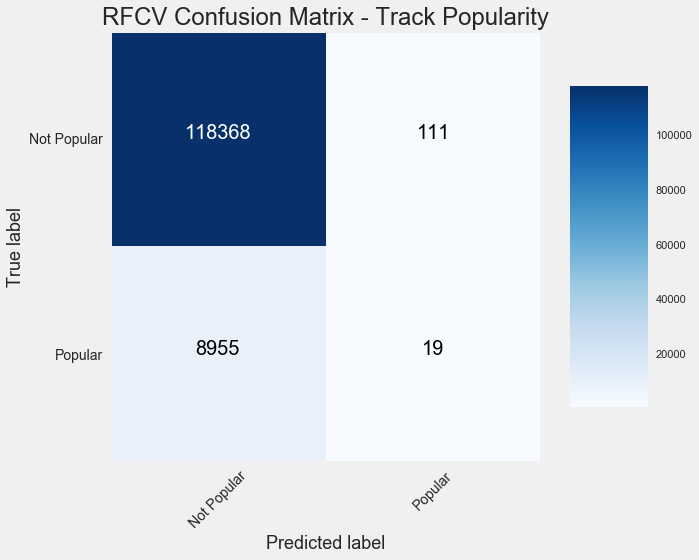

In [110]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(rf_cv_cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        rf_cv_cm = rf_cv_cm.astype('float') / rf_cv_cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(rf_cv_cm)

    # Plot the confusion matrix
    fig14 = plt.figure(figsize = (10, 10))
    plt.imshow(rf_cv_cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = rf_cv_cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(rf_cv_cm.shape[0]), range(rf_cv_cm.shape[1])):
        plt.text(j, i, format(rf_cv_cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if rf_cv_cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.tight_layout()
    #plt.savefig('Images/rf_cv_confusion_matrix.png')

# Confusion matrix
rf_cv_cm = confusion_matrix(y3_test, rf_predictions)
plot_confusion_matrix(rf_cv_cm, classes = ['Not Popular', 'Popular'],
                      title = 'RFCV Confusion Matrix - Track Popularity')

#plt.savefig('rf_cv_cm.png')

### 3. Random Forest w/ SMOTE

#### a) Resampling w/ SMOTE 

In [119]:
print(y3_train.track_popularity_50.value_counts())
smote = SMOTE()
X3_train_resampled_rf, y3_train_resampled_rf = smote.fit_sample(X3_train, y3_train.track_popularity_50) 
print(pd.Series(y3_train_resampled_rf).value_counts())

0    473918
1     35894
Name: track_popularity_50, dtype: int64
1    473918
0    473918
dtype: int64


#### b) Random Forest w/ SMOTE Model

In [120]:
# train model
rfc_smote = RandomForestClassifier(n_estimators=9).fit(X3_train_resampled_rf, y3_train_resampled_rf)

#predict on test set
rfc_smote_pred = rfc_smote.predict(X3_test)

#### c) Scores

In [121]:
# Checking Accuracy
print('Accuracy:', metrics.accuracy_score(y3_test, rfc_smote_pred))

# Checking Precision
print('Precision:', metrics.precision_score(y3_test, rfc_smote_pred))
    
# F1 Score
print('F1:', metrics.f1_score(y3_test, rfc_smote_pred))

# Checking Recall
print('Recall:', metrics.recall_score(y3_test, rfc_smote_pred))

Accuracy: 0.906491020219218
Precision: 0.11201897733263047
F1: 0.06657268170426064
Recall: 0.047359037218631606


#### d) Confusion Matrix

In [127]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
rf_smote_cm = confusion_matrix(y3_test, rfc_smote_pred)
rf_smote_cm

array([[115110,   3369],
       [  8549,    425]])

In [126]:
pd.DataFrame(confusion_matrix(y3_test, rfc_smote_pred), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,115110,3369
actual 1,8549,425


Confusion matrix, without normalization
[[118368    111]
 [  8955     19]]


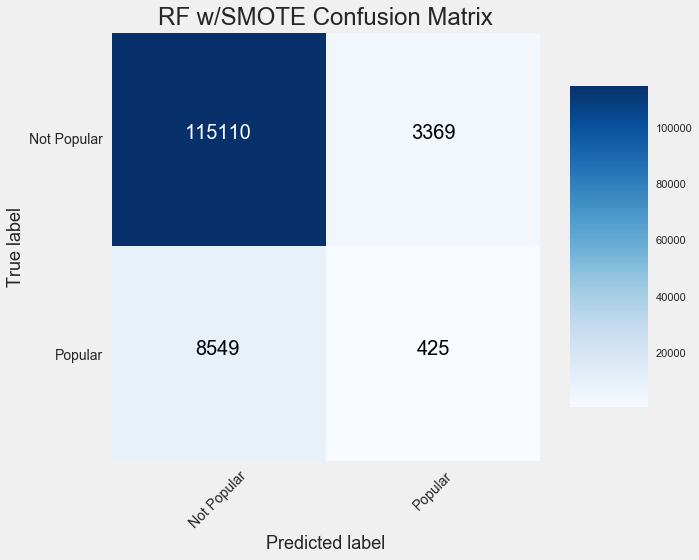

In [129]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(rf_smote_cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        rf_smote_cm = rf_smote_cm.astype('float') / rf_smote_cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(rf_cv_cm)

    # Plot the confusion matrix
    fig14 = plt.figure(figsize = (10, 10))
    plt.imshow(rf_smote_cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = rf_smote_cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(rf_smote_cm.shape[0]), range(rf_smote_cm.shape[1])):
        plt.text(j, i, format(rf_smote_cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if rf_smote_cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.tight_layout()
    #plt.savefig('Images/rf_cv_confusion_matrix.png')

# Confusion matrix
rf_smote_cm = confusion_matrix(y3_test, rfc_smote_pred)
plot_confusion_matrix(rf_smote_cm, classes = ['Not Popular', 'Popular'],
                      title = 'RF w/SMOTE Confusion Matrix')

plt.savefig('Images/rf_smote_cm.png')

### 4. Random Forest with Random Search Cross Validation

#### a) Using RandomizedSearchCV

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

clf = RandomForestClassifier() #Initialize with whatever parameters you want to

# 10-Fold Cross validation
clf_pred = np.mean(cross_val_score(clf, X3_train, 
                                   y3_train, cv=10))

In [116]:
param_distributions = {'n_estimators': [100, 200],
                       #'max_features': ['auto', 'sqrt', 'log2']
                      }
#300, 400, 500

In [124]:
from sklearn.model_selection import RandomizedSearchCV
CV_rfc = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, cv= 5, scoring='roc_auc')
CV_rfc.fit(X3_train, y3_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [ ]:
CV_rfc.best_params_

In [ ]:
rfc1 = RandomForestClassifier(n_estimators= 20)

In [ ]:
rfc1.fit(X3_train, y3_train)

In [ ]:
rfc_rscv_pred = rfc1.predict(X3_test)

In [ ]:
print("Accuracy for Random Forest on CV data: ", accuracy_score(y3_test, rfc_rscv_pred))

#### b) Using GridSearchCV

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

clf = RandomForestClassifier() #Initialize with whatever parameters you want to

# 10-Fold Cross validation
clf_pred = np.mean(cross_val_score(clf, X3_train, 
                                   y3_train, cv=10))

In [25]:
param_grid = {
   'n_estimators': [20, 100],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [4,5,6,7,8],
#    'criterion' :['gini', 'entropy']
}

In [ ]:
from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X3_train, y3_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
rfc1 = RandomForestClassifier(n_estimators= 20)

In [ ]:
rfc1.fit(X3_train, y3_train)

In [ ]:
rfc_rscv_pred = rfc1.predict(X3_test)

In [ ]:
print("Accuracy for Random Forest on CV data: ", accuracy_score(y3_test, rfc_rscv_pred))